In [1]:
import os
import cv2
import random
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
classes = {0: 'Yangwei',
           1: 'Others'}
#            2:'Yangwei with mask',
#            3:'Others with mask'}

In [3]:
def get_images(path):
    for filename in os.listdir(path):
        if filename.endswith('.jpg'):
            filename = path + '/' + filename
            image = cv2.imread(filename)
            image = cv2.resize(image, (size, size))
            image = image.astype('float32') / 255.0 # convert image from (0,255) to (0,1)
            image = (image-0.5) / 0.5 # convert image from (0,1) to (-1,1)
            image = image.transpose(2,0,1) # conver dimension from (64,64,3) to (3,64,64)
            images_raw.append(image)
    
            # convert the labels into 0 or 1
            if path==path_myface:
                labels_raw.append(0)
            elif path==path_others:
                labels_raw.append(1)
            elif path==path_myface_masked:
                labels_raw.append(0)
            else:
                labels_raw.append(1)

In [4]:
path_myface = './data/faces_my'
path_others = './data/faces_other'
path_myface_masked = './data/faces_my_masked'
path_other_masked = './data/faces_other_masked'

size = 64
images_raw = []
labels_raw = []

get_images(path_myface)
get_images(path_others)
get_images(path_myface_masked)
get_images(path_other_masked)


images_raw = np.array(images_raw)
labels_raw = np.array(labels_raw)

In [5]:
train_X, test_X, train_y, test_y = train_test_split(images_raw, labels_raw, test_size=0.2, random_state=546)
train_X = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_y)
test_X = torch.from_numpy(test_X)
test_y = torch.from_numpy(test_y)

print('train set:', train_X.shape)
print('train labels', train_y.shape)
print('test set:', test_X.shape)
print('test labels', test_y.shape)

train set: torch.Size([6400, 3, 64, 64])
train labels torch.Size([6400])
test set: torch.Size([1600, 3, 64, 64])
test labels torch.Size([1600])


In [6]:
train_batch_size = 16
test_batch_size = 16

trainset = TensorDataset(train_X, train_y)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size, shuffle=True)

testset = TensorDataset(test_X, test_y)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=True)

torch.Size([16, 3, 64, 64])
torch.Size([16])
tensor([1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1], dtype=torch.int32)


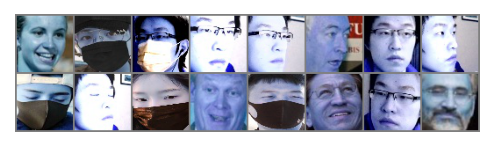

In [7]:
def imshow(img):
    img = img*0.5 + 0.5     # unnormalize
    npimg = img.numpy()
    
    figure(num=None, figsize=(4, 3), dpi=150, edgecolor='k')
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

# show images
imshow(torchvision.utils.make_grid(images))
print(labels)

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Convolution 1
        # input: 64*64*3
        # output 64*64*32
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        
        # Avg pool 1
        # output: 32*32*32
        self.avgpool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        # Dropout for regularization
        self.dropout = nn.Dropout(p=0.5)
        
        # Convolution 2
        # output: 32*32*64
        self.cnn2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        
        # Avg pool 2
        # output: 16*16*64
        self.avgpool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5)
        
        # Convolution 3
        # output: 16*16*64
        self.cnn3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()

        # Avg pool 3
        # output: 8*8*64
        self.avgpool3 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5)
        
        # Fully Connected 1
        self.fc1 = nn.Linear(8*8*64, 512)
        self.batchnorm4 = nn.BatchNorm1d(512)
        self.relu4 = nn.ReLU()
        
        # Fully Connected 2
        self.fc2 = nn.Linear(512, 2)
        self.sigmoid = nn.Softmax(dim=1)

    def forward(self, x):
        #Convolution 1
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu1(out)
        
        #Avg pool 1
        out = self.avgpool1(out)
        
        #Convolution 2
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu2(out)
        
        #Avg pool 2
        out = self.avgpool2(out)

        #Convolution 3
        out = self.cnn3(out)
        out = self.batchnorm3(out)
        out = self.relu3(out)
        
        #Avg pool 3
        out = self.avgpool3(out)
        
        #Resize
        out = out.view(out.size(0), -1)
        
        #Dropout
        out = self.dropout(out)
        
        #Fully connected 1
        out = self.fc1(out)
        out = self.batchnorm4(out)
        out = self.relu4(out)

        #Fully connected 2
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out
    
net = Net()

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("Device name:", torch.cuda.get_device_name(0))

model = Net().to(device)
summary(model, (3,64,64))

Device: cuda
Device name: GeForce RTX 2070
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
         AvgPool2d-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,496
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
         AvgPool2d-8           [-1, 64, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          36,928
      BatchNorm2d-10           [-1, 64, 16, 16]             128
             ReLU-11           [-1, 64, 16, 16]               0
        AvgPool2d-12             [-1, 64, 8, 8]               0
          Dropout-13                 [-1, 4096]             

In [10]:
net.to(device)

writer = SummaryWriter()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.00001)

In [11]:
overall_step = 0
epochs = 40

for epoch in range(epochs):  # loop over the dataset multiple times
    print('epoch:', epoch)
    running_loss = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
#         inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)

        # Make predictions, calculate accuracy and update your weights once
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
#         loss = criterion(outputs, labels)
        loss = criterion(outputs, labels.long())
#         loss = criterion(outputs, torch.max(labels, 1)[1])
        loss.backward()
        optimizer.step()
        _, prediction = torch.max(outputs,1)
        accuracy = (labels == prediction.squeeze()).float().mean()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
#             print('Epoch: %d, Batch: %5d, loss: %.3f' %(epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
            
            #Any thing that is added to the "info" gets plotted in tensorboard
            info = {'loss' : loss.item(), 'accuracy': accuracy.item()}      
            for tag, value in info.items():
                writer.add_scalar(tag, value, overall_step)
                writer.flush()

            overall_step+=1

writer.close()
print('Finished Training')

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
Finished Training


In [12]:
def get_acc_all(): 
    correct = 0
    total = 0
#     net.eval()

    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: %f %%' % (100 * correct / total))

In [13]:
get_acc_all()

Accuracy of the network on the test images: 99.812500 %


In [14]:
def get_acc_class():
    class_correct = list(0. for i in range(2))
    class_total = list(0. for i in range(2))
#     net.eval()

    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(2):
        print('Accuracy of %5s : %f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

In [15]:
get_acc_class()

Accuracy of Yangwei : 99.528302 %
Accuracy of Others : 99.468085 %


In [16]:
path_model = './model'
if not os.path.exists(path_model):
    os.makedirs(path_model)

torch.save(net.state_dict(), './model/model.pkl')